In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import wraps, lru_cache
from numba import jit, njit, prange
import numba
from tqdm import tqdm
import time

np.set_printoptions(precision=8, suppress=True)   # settings for printing numpy objects


kT_arr = np.arange(1, 5.1, 0.1)     # array of kT values
L_x = np.arange(2, 9)               # array of Lx values

In [3]:
'''
Средняя энергия для  𝐿𝑥=4  при температурах  𝑘𝑇∈[1,1.1,...,5.0] :


[-1.99715844 -1.99396091 -1.98856632 -1.98016965 -1.96786355 -1.95064256
 -1.9274244  -1.89711215 -1.85871667 -1.81153907 -1.75538029 -1.69071311
 -1.61874282 -1.54131149 -1.46065977 -1.37911648 -1.29880759 -1.22145424
 -1.14828469 -1.0800446  -1.01706963 -0.95938399 -0.90679838 -0.85899291
 -0.8155803  -0.77615005 -0.74029707 -0.70763857 -0.67782287 -0.65053286
 -0.62548613 -0.60243323 -0.58115501 -0.56145948 -0.5431787  -0.52616582
 -0.5102923  -0.49544555 -0.48152673 -0.46844889]
'''

'\nСредняя энергия для  𝐿𝑥=4  при температурах  𝑘𝑇∈[1,1.1,...,5.0] :\n\n\n[-1.99715844 -1.99396091 -1.98856632 -1.98016965 -1.96786355 -1.95064256\n -1.9274244  -1.89711215 -1.85871667 -1.81153907 -1.75538029 -1.69071311\n -1.61874282 -1.54131149 -1.46065977 -1.37911648 -1.29880759 -1.22145424\n -1.14828469 -1.0800446  -1.01706963 -0.95938399 -0.90679838 -0.85899291\n -0.8155803  -0.77615005 -0.74029707 -0.70763857 -0.67782287 -0.65053286\n -0.62548613 -0.60243323 -0.58115501 -0.56145948 -0.5431787  -0.52616582\n -0.5102923  -0.49544555 -0.48152673 -0.46844889]\n'

In [7]:
def timeit(func):
    
    """
    Decorator for measuring time of function execution.
    
    """

    @wraps(func)
    def timeit_wrapper(*args, **kwargs):

        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time

        return (result, total_time)

    return timeit_wrapper

In [8]:
@njit(parallel=True)
def get_energy_expectation(m: int, n: int, kT_arr):
    
    """
    Calculate mathematical expectation of the energy of ferromagnetic
    for certain shape and list of kT values.
    
    Parameters:
    ---------------
    m: int
       Width of ferromagnetic grid.
    
    n: int
       Length of ferromagnetic grid.
    
    kT_arr: array_like[float]
            List of kT values.
        
        
    Returns:
    ---------------
    res_arr: array_like[int]
             Array with calculated energy expectations for each kT value from kT_arr.
             -> len(res_arr) == len(kT_arr)
    
    """

    res_arr = np.empty(len(kT_arr))
    
    for i in prange(len(kT_arr)):        # parallel loop over kT values
        statsum = 0
        en_sum = 0
        kT = kT_arr[i]
        
        # Iterate through all spin matrices using binary numbers from 0 to 2**(m*n - 1)
        # (-1) in power of 2 is because of using symmetry of the energy function.
        # So, we use half as many spin configurations (then, we multiply each result energy by 2,
        # but the same 2 appears in statsum -> they erase and I don't write them in code)
        for num in range(2 ** (m * n - 1)):
            num = numba.int64(num)                          # convert num to numba type (works a bit faster)
            spin_mat = np.empty(m * n, dtype=np.int8)
            
            # Change 0 -> -1 in binary representation
            for cell in range(m * n):                       
                if (num & 1 == 0):
                    spin_mat[cell] = -1
                else:
                    spin_mat[cell] = 1
                num = num >> 1
                
            spin_mat = spin_mat.reshape((m, n))             # reshaping result sequence to a matrix
            
            # Energy calculation block
            energy = 0
            for k in range(m):
                for j in range(n):
                    energy -= spin_mat[k][j] * spin_mat[(k+1)%m][j] + spin_mat[k][j] * spin_mat[k][(j+1)%n]
            en_sum += (energy * np.exp(((-1) * energy) / kT))
            statsum += np.exp((-1) * energy / kT)
            
        res_arr[i] = (en_sum / statsum) / (m * n)           # normalize result expectation by the number of cells 
    
    return res_arr

In [9]:
# Test function for (6 * 4) grid

res_arr, t = get_energy_expectation(6, 4, kT_arr=kT_arr)
print(f"Result: {res_arr}")
print(f"Time: {t:.4f}")

Result: [-1.99715857 -1.99396113 -1.9885651  -1.98015781 -1.96780519 -1.95042956
 -1.92678909 -1.89549406 -1.8551112  -1.80440326 -1.74270304 -1.67032537
 -1.58882722 -1.50092868 -1.41005807 -1.31969261 -1.23276666 -1.15134108
 -1.07656139 -1.00881115 -0.94793988 -0.8934793  -0.84480933 -0.8012682
 -0.76221687 -0.72707144 -0.69531564 -0.66650184 -0.6402464  -0.61622247
 -0.59415234 -0.57380002 -0.55496464 -0.53747479 -0.52118369 -0.50596511
 -0.49171009 -0.47832415 -0.46572503 -0.45384075 -0.44260812]
Time: 45.6008


In [11]:
# Main calculation

energies = np.empty((7, 41))

for Lx in range(2, 9):
    res_arr, t = get_energy_expectation(Lx, 4, kT_arr=kT_arr)
    energies[Lx - 2] = res_arr
    print(f"Lx = {Lx}")
    print(f"Result: {res_arr}")
    print(f"Computation time: {t} seconds\n")

Lx = 2
Result: [-1.99509474 -1.98967862 -1.98074878 -1.96731117 -1.94851445 -1.92375828
 -1.89277291 -1.85565639 -1.81286316 -1.76514762 -1.71347563 -1.65892227
 -1.60257405 -1.5454491  -1.48844224 -1.43229537 -1.3775895  -1.3247523
 -1.27407538 -1.22573609 -1.17982015 -1.13634286 -1.09526756 -1.05652101
 -1.02000562 -0.98560898 -0.9532109  -0.92268862 -0.89392045 -0.86678827
 -0.84117913 -0.8169862  -0.79410926 -0.77245486 -0.75193626 -0.73247322
 -0.71399168 -0.69642337 -0.67970548 -0.66378023 -0.64859447]
Computation time: 0.0010825000000522778 seconds

Lx = 3
Result: [-1.99711779 -1.99383665 -1.98825271 -1.97949351 -1.96659182 -1.94853206
 -1.92432618 -1.89312223 -1.85433583 -1.80777902 -1.75375117 -1.69305981
 -1.62695673 -1.55700043 -1.48487836 -1.41223059 -1.34050963 -1.27089443
 -1.20425882 -1.14118312 -1.08199278 -1.02680913 -0.97560137 -0.92823315
 -0.88450084 -0.84416295 -0.80696158 -0.77263715 -0.7409381  -0.71162671
 -0.68448222 -0.65930219 -0.63590256 -0.61411702 -0.59379

In [15]:
np.save("ferr_energies.npy", energies)                 # save result

In [16]:
loaded_energies = np.load("ferr_energies.npy")         # load result 

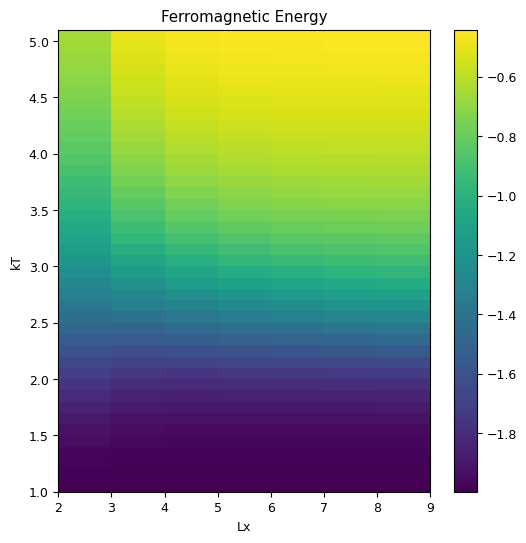

In [22]:
# Heatmap for calculated energy expectations

plt.figure(figsize=(6,6))
f = plt.pcolormesh(np.swapaxes(loaded_energies,0,1), cmap='viridis')
ax = plt.colorbar(f)
plt.xlabel("Lx")
plt.ylabel("kT")
plt.xticks(np.arange(0, 8, 1), np.arange(2, 10, 1))
plt.yticks(np.arange(0, 42, 5), np.linspace(1.0, 5.0, num=9))
plt.title('Ferromagnetic Energy')
plt.rcParams['font.size'] = 9
plt.show()